In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('ml-latest-small/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
df_movies = pd.read_csv('ml-latest-small/movies.csv')
df_join = pd.merge(df_movies, df, how='inner', on='movieId')
df_join.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [4]:
def get_ratings_matrix(df, train_size=0.75):
    user_to_row = {}
    movie_to_column = {}
    df_values = df.values
    n_dims = 10
    parameters = {}
    
    uniq_users = np.unique(df_values[:, 3])
    uniq_movies = np.unique(df_values[:, 0])

    for i, user_id in enumerate(uniq_users):
        user_to_row[user_id] = i

    for j, movie_id in enumerate(uniq_movies):
        movie_to_column[movie_id] = j
    
    n_users = len(uniq_users)
    n_movies = len(uniq_movies)
    
    R = np.zeros((n_users, n_movies))
    
    df_copy = df.copy()
    train_set = df_copy.sample(frac=train_size, random_state=0)
    test_set = df_copy.drop(train_set.index)
    
    for index, row in train_set.iterrows():
        i = user_to_row[row.userId]
        j = movie_to_column[row.movieId]
        R[i, j] = row.rating

    return R, train_set, test_set, n_dims, n_users, n_movies, user_to_row, movie_to_column

In [5]:
R, train_set, test_set, n_dims, n_users, n_movies, user_to_row, movie_to_column = get_ratings_matrix(df_join, 0.8)
parameters = {}

In [6]:
def initialize_parameters(lambda_U, lambda_V):
    U = np.zeros((n_dims, n_users), dtype=np.float64)
    V = np.random.normal(0.0, 1.0 / lambda_V, (n_dims, n_movies))
    
    parameters['U'] = U
    parameters['V'] = V
    parameters['lambda_U'] = lambda_U
    parameters['lambda_V'] = lambda_V

In [7]:
def update_parameters():
    U = parameters['U']
    V = parameters['V']
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    
    for i in range(n_users):
        V_j = V[:, R[i, :] > 0]
        U[:, i] = np.dot(np.linalg.inv(np.dot(V_j, V_j.T) + lambda_U * np.identity(n_dims)), np.dot(R[i, R[i, :] > 0], V_j.T))
        
    for j in range(n_movies):
        U_i = U[:, R[:, j] > 0]
        V[:, j] = np.dot(np.linalg.inv(np.dot(U_i, U_i.T) + lambda_V * np.identity(n_dims)), np.dot(R[R[:, j] > 0, j], U_i.T))
        
    parameters['U'] = U
    parameters['V'] = V
    

In [8]:
def log_a_posteriori():
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    U = parameters['U']
    V = parameters['V']
    
    UV = np.dot(U.T, V)
    R_UV = (R[R > 0] - UV[R > 0])
    
    return -0.5 * (np.sum(np.dot(R_UV, R_UV.T)) + lambda_U * np.sum(np.dot(U, U.T)) + lambda_V * np.sum(np.dot(V, V.T)))

In [9]:
def predict(user_id, movie_id):
    U = parameters['U']
    V = parameters['V']
    
    r_ij = U[:, user_to_row[user_id]].T.reshape(1, -1) @ V[:, movie_to_column[movie_id]].reshape(-1, 1)

    max_rating = parameters['max_rating']
    min_rating = parameters['min_rating']

    return 0 if max_rating == min_rating else ((r_ij[0][0] - min_rating) / (max_rating - min_rating)) * 5.0

In [10]:
def evaluate(dataset):
    ground_truths = []
    predictions = []
    
    for index, row in dataset.iterrows():
        ground_truths.append(row.loc['rating'])
        predictions.append(predict(row.loc['userId'], row.loc['movieId']))
    
    return mean_squared_error(ground_truths, predictions, squared=False)

In [11]:
def update_max_min_ratings():
    U = parameters['U']
    V = parameters['V']

    R = U.T @ V
    min_rating = np.min(R)
    max_rating = np.max(R)

    parameters['min_rating'] = min_rating
    parameters['max_rating'] = max_rating

In [12]:
def train(n_epochs):
    initialize_parameters(0.3, 0.3)
    log_aps = []
    rmse_train = []
    rmse_test = []

    update_max_min_ratings()
    rmse_train.append(evaluate(train_set))
    rmse_test.append(evaluate(test_set))
    
    for k in range(n_epochs):
        update_parameters()
        log_ap = log_a_posteriori()
        log_aps.append(log_ap)

        if (k + 1) % 10 == 0:
            update_max_min_ratings()

            rmse_train.append(evaluate(train_set))
            rmse_test.append(evaluate(test_set))
            print('Log p a-posteriori at iteration', k + 1, ':', log_ap)

    update_max_min_ratings()

    return log_aps, rmse_train, rmse_test

In [13]:
log_ps, rmse_train, rmse_test = train(150)

Log p a-posteriori at iteration 10 : -17034.916470960623
Log p a-posteriori at iteration 20 : -12817.553333300948
Log p a-posteriori at iteration 30 : -11594.075095057755
Log p a-posteriori at iteration 40 : -11059.873187656916
Log p a-posteriori at iteration 50 : -10769.073910582605
Log p a-posteriori at iteration 60 : -10583.455277402307
Log p a-posteriori at iteration 70 : -10449.778012132174
Log p a-posteriori at iteration 80 : -10345.968717776552
Log p a-posteriori at iteration 90 : -10268.031699268045
Log p a-posteriori at iteration 100 : -10199.219827874183
Log p a-posteriori at iteration 110 : -10140.227810475342
Log p a-posteriori at iteration 120 : -10086.937736965965
Log p a-posteriori at iteration 130 : -10043.459957716876
Log p a-posteriori at iteration 140 : -10010.646861509378
Log p a-posteriori at iteration 150 : -9986.847228851519


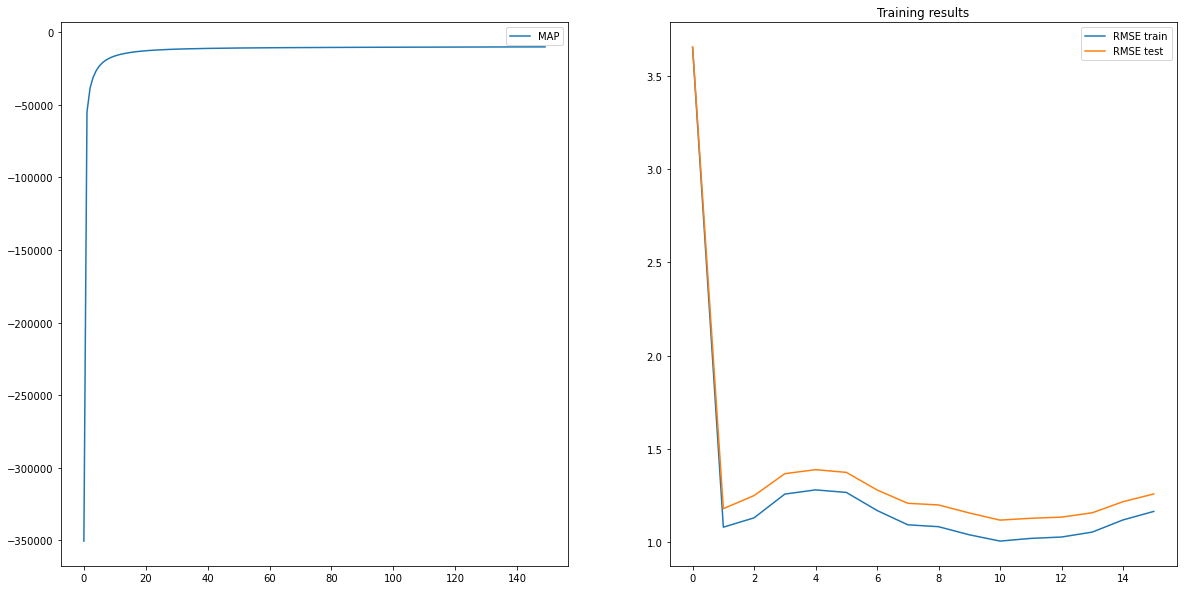

In [14]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plt.title('Training results')
ax1.plot(np.arange(len(log_ps)), log_ps, label='MAP')
ax1.legend()

ax2.plot(np.arange(len(rmse_train)), rmse_train, label='RMSE train')
ax2.plot(np.arange(len(rmse_test)), rmse_test, label='RMSE test')
ax2.legend()

plt.show()

In [15]:
print('RMSE of training set:', evaluate(train_set))
print('RMSE of testing set:', evaluate(test_set))

RMSE of training set: 1.1638120880043699
RMSE of testing set: 1.257642346327013


In [16]:
user_id = 45
df_join[df_join['userId'] == user_id].sort_values(by=['rating'], ascending=False).head(10)


,movieId,title,genres,userId,rating,timestamp
39202,2078,"Jungle Book, The (1967)",Animation|Children|Comedy|Musical,45,5.0,950726248
46609,2694,Big Daddy (1999),Comedy,45,5.0,951170525
46142,2657,"Rocky Horror Picture Show, The (1975)",Comedy|Horror|Musical|Sci-Fi,45,5.0,950741248
55533,3578,Gladiator (2000),Action|Adventure|Drama,45,5.0,1020803425
33101,1584,Contact (1997),Drama|Sci-Fi,45,5.0,950740871
56625,3717,Gone in 60 Seconds (2000),Action|Crime,45,5.0,1007994717
45369,2580,Go (1999),Comedy|Crime,45,5.0,951756858
56996,3753,"Patriot, The (2000)",Action|Drama|War,45,5.0,1007995101
57287,3793,X-Men (2000),Action|Adventure|Sci-Fi,45,5.0,1007995171
57418,3798,What Lies Beneath (2000),Drama|Horror|Mystery,45,5.0,1007995171


In [17]:
df_join[df_join['userId'] == user_id].sort_values(by=['rating']).head(10)

,movieId,title,genres,userId,rating,timestamp
53154,3270,"Cutting Edge, The (1992)",Comedy|Drama|Romance,45,1.0,950718581
5111,173,Judge Dredd (1995),Action|Crime|Sci-Fi,45,1.0,950741335
44072,2470,Crocodile Dundee (1986),Adventure|Comedy,45,1.0,950740565
67895,5585,Ernest Scared Stupid (1991),Comedy,45,1.0,1034344038
62486,4502,Ernest Saves Christmas (1988),Children|Comedy,45,1.0,1034344018
60222,4104,Ernest Goes to Camp (1987),Comedy,45,1.0,1034344018
53115,3268,Stop! Or My Mom Will Shoot (1992),Action|Comedy,45,1.0,950740376
46306,2672,"Thirteenth Floor, The (1999)",Drama|Sci-Fi|Thriller,45,1.0,950741061
54299,3439,Teenage Mutant Ninja Turtles II: The Secret of...,Action|Children|Fantasy,45,1.0,1034344018
15160,569,Little Big League (1994),Comedy|Drama,45,2.0,950722240


In [18]:

predictions = np.zeros((n_movies, 1))
movie_to_column_items = np.array(list(movie_to_column.items()))
df_result = pd.DataFrame(columns=['UserID', 'MovieID', 'Movie', 'Genres', 'Prediction'])

for i, movie in enumerate(movie_to_column_items):
    predictions[i] = predict(user_id, movie[0])
    
indices = np.argsort(-predictions, axis=0)

for j in range(10):
    movie_id = int(movie_to_column_items[np.where(movie_to_column_items[:, 1] == indices[j])][0][0])
    df_row = pd.DataFrame({
        'UserID': user_id,
        'MovieID': movie_id,
        'Movie': df_movies[df_movies['movieId'] == movie_id].iloc[0]['title'],
        'Genres': df_movies[df_movies['movieId'] == movie_id].iloc[0]['genres'],
        'Prediction': predictions[indices[j]][0][0]
    }, index=[j])
    df_result = df_result.append(df_row, sort=False)
    
df_result

,UserID,MovieID,Movie,Genres,Prediction
0,45,5785,Jackass: The Movie (2002),Action|Comedy|Documentary,3.536947
1,45,3441,Red Dawn (1984),Action|Drama|War,3.356678
2,45,3040,Meatballs (1979),Comedy,3.351842
3,45,2118,"Dead Zone, The (1983)",Thriller,3.291807
4,45,1378,Young Guns (1988),Action|Comedy|Western,3.265543
5,45,84152,Limitless (2011),Sci-Fi|Thriller,3.262400
6,45,1711,Midnight in the Garden of Good and Evil (1997),Crime|Drama|Mystery,3.250727
7,45,267,Major Payne (1995),Comedy,3.246677
8,45,151,Rob Roy (1995),Action|Drama|Romance|War,3.230802
9,45,5617,Secretary (2002),Comedy|Drama|Romance,3.228478


In [19]:
df_result = pd.DataFrame(columns=['UserID', 'MovieID', 'Movie', 'Genres', 'Prediction'])
indices = np.argsort(predictions, axis=0)

for j in range(10):
    movie_id = int(movie_to_column_items[np.where(movie_to_column_items[:, 1] == indices[j])][0][0])
    df_row = pd.DataFrame({
        'UserID': user_id,
        'MovieID': movie_id,
        'Movie': df_movies[df_movies['movieId'] == movie_id].iloc[0]['title'],
        'Genres': df_movies[df_movies['movieId'] == movie_id].iloc[0]['genres'],
        'Prediction': predictions[indices[j]][0][0]
    }, index=[j])
    df_result = df_result.append(df_row, sort=False)
    
df_result

,UserID,MovieID,Movie,Genres,Prediction
0,45,2171,Next Stop Wonderland (1998),Comedy|Drama|Romance,1.926792
1,45,218,Boys on the Side (1995),Comedy|Drama,2.040960
2,45,3328,Ghost Dog: The Way of the Samurai (1999),Crime|Drama,2.045541
3,45,3608,Pee-wee's Big Adventure (1985),Adventure|Comedy,2.051790
4,45,71745,Where the Wild Things Are (2009),Adventure|Children|Drama|Fantasy|IMAX,2.090774
5,45,6993,Hannah and Her Sisters (1986),Comedy|Drama|Romance,2.100771
6,45,1760,Spice World (1997),Comedy,2.100896
7,45,2110,Dead Men Don't Wear Plaid (1982),Comedy|Crime|Thriller,2.128861
8,45,3851,I'm the One That I Want (2000),Comedy,2.129240
9,45,106,Nobody Loves Me (Keiner liebt mich) (1994),Comedy|Drama,2.130075
